In [1]:
import os
import copy
import pickle
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt


In [2]:
def mnist_iid_samples(dataset, num_users, subset_size):
    total_indices = np.arange(len(dataset))
    np.random.shuffle(total_indices)

    ds = []
    sub_idx =[]
    for i in range(num_users):
        indices = total_indices[i*subset_size:(i+1)*subset_size]
        sub_idx.append(indices)
        original = [dataset[i] for i in indices]
        ds.append([(x,label % 2, label) for (x,label) in original])
    return ds, sub_idx


def mnist_non_iid_samples(dataset, num_users, sub_size):
    total_indices = np.arange(len(dataset))
    np.random.shuffle(total_indices)

    ds = []
    sub_idx =[]
    for i in range(num_users):
        subset_label = np.random.choice(range(10), 6, replace=False)
        subset_idx =  [i for i, (x,y) in enumerate(dataset) if y in subset_label]
        indices = np.random.choice(subset_idx, sub_size, replace=False)
        sub_idx.append(indices)
        original = [dataset[i] for i in indices]
        ds.append([(x,label % 2, label) for (x,label) in original])
    return ds, sub_idx

    
    
def prepare_mnist_data(dim, iid=0, num_dev = 5, num_ds = 300):

    transform = transforms.Compose([
        transforms.Resize((dim, dim)),  # Resize the image to 14x14
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    mnist_train = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST('data/mnist', train=False, download=True, transform=transform)

    mnist_even_odd_test= [(x,label % 2, label) for (x,label) in mnist_test]
    mnist_even_odd_train= [(x,label % 2, label) for (x,label) in mnist_train]

    if iid:
        return mnist_even_odd_test, mnist_even_odd_train, *mnist_iid_samples(mnist_train, num_dev, num_ds)
    return mnist_even_odd_test, mnist_even_odd_train, *mnist_non_iid_samples(mnist_train, num_dev, num_ds)
    

In [3]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.l1 = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return self.softmax(x)
    
    def reset(self):
        nn.init.uniform_(self.l1.weight, -torch.sqrt(torch.tensor(1/self.dim_in)), torch.sqrt(torch.tensor(1/self.dim_in)))
        nn.init.uniform_(self.l2.weight, -torch.sqrt(torch.tensor(1/self.dim_hidden)), torch.sqrt(torch.tensor(1/self.dim_hidden)))
#         nn.init.uniform_(self.l1.bias, -r/10, r/10)
#         nn.init.uniform_(self.l2.bias, -r/10, r/10)
    
    def parameter_range(self):
        par_dict = self.state_dict()
        w1_min = par_dict["l1.weight"].min().item()
        w1_max = par_dict["l1.weight"].max().item()
        w2_min = par_dict["l2.weight"].min().item()
        w2_max = par_dict["l2.weight"].max().item()        
        b1_min = par_dict["l1.bias"].min().item()
        b1_max = par_dict["l1.bias"].max().item()
        b2_min = par_dict["l2.bias"].min().item()
        b2_max = par_dict["l2.bias"].max().item() 
        return [[w1_min, w1_max], [w2_min, w2_max], [b1_min, b1_max], [b2_min, b2_max]]

In [9]:
def test_inference(model, dataset, loss):
    model.eval()
    l, correct = 0.0, 0.0

    testloader = DataLoader(dataset, batch_size=2000, shuffle=False)
    with torch.no_grad():
        for i, data in enumerate(testloader):
            x = data[0]
            labels = data[1]
            # Inference
            outputs = model(x)
            batch_loss = loss(outputs, labels)
            l += batch_loss.item()

            # Prediction
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            break

    return correct/2000, l


In [29]:
def train_global(model, dataset_train, steps, batch_size, lr, dataset_test=None, eval_every=1):
    model.reset()
    data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    optim = torch.optim.SGD(model.parameters(), lr)
    CEloss = nn.CrossEntropyLoss()
    

    test_accuracy = []
    test_loss = []
    train_loss = []
    
    step_count = 0
    
    for t in range(steps * batch_size// len(dataset_train)):
        for i, data in enumerate(data_loader):
            inputs = data[0]
            labels = data[1]
            optim.zero_grad()

            output = model(inputs)
            loss = CEloss(output, labels)
            train_loss.append(loss.item())
            loss.backward()
            optim.step()
            
            step_count += 1

            if dataset_test:
                if step_count % eval_every == 0:
                    acc, l = test_inference(model, dataset_test, CEloss)
                    test_accuracy.append(acc)
                    test_loss.append(l)
            
    return  train_loss, test_loss, test_accuracy




In [28]:
def train_global_partitioned(model, client_data, total_steps, local_steps, batch_size, lr, dataset_test=None):
    model.reset()
    data_loaders = [DataLoader(dataset_train, batch_size=batch_size, shuffle=True) for dataset_train in client_data]
    optim = torch.optim.SGD(model.parameters(), lr)
    CEloss = nn.CrossEntropyLoss()
    

    test_accuracy = []
    test_loss = []
    train_loss = []
    
    
    for t in range(total_steps // (len(client_data) * local_steps)):
        for data_loader in data_loaders:
            tot_loss = 0
            for j in range(round(local_steps * batch_size/len(client_data[0]))):
                for i, data in enumerate(data_loader):
                    inputs = data[0]
                    labels = data[1]
                    optim.zero_grad()

                    output = model(inputs)
                    loss = CEloss(output, labels)
                    tot_loss += loss.item()
                    loss.backward()
                    optim.step()
            train_loss.append(tot_loss)
            if dataset_test:
                acc, l = test_inference(model, dataset_test, CEloss)
                test_accuracy.append(acc)
                test_loss.append(l)

    return  train_loss, test_loss, test_accuracy



In [41]:

class Client:
    def __init__(self, dim_in, dim_hidden, dim_out, dataset, mode = 'FP'):
        self.mode = mode   # FP: FLOATING POINT, QAT: QUANTIZATION AWARE TRAINING
        self.dataset = dataset
 
        if mode == 'FP':
            self.model = MLP(dim_in, dim_hidden, dim_out)
            self.global_model = MLP(dim_in, dim_hidden, dim_out)
            
#         else:
#             self.model = QMLP(dim_in, dim_hidden, dim_out)
#             self.global_model = QMLP(dim_in, dim_hidden, dim_out)
        self.loss = nn.CrossEntropyLoss()
        
        
    def reset(self):
        self.model.reset()  
        self.global_model.load_state_dict(self.model.state_dict())
        
    def local_SGD(self, batch_size, steps, lr):
        data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.SGD(self.model.parameters(), lr)

        tot_loss = 0 
        for j in range(round(steps * batch_size/len(self.dataset))):
            for i, data in enumerate(data_loader):
                inputs = data[0]
                labels = data[1]
                optim.zero_grad()
                output = self.model(inputs)
                loss = self.loss(output, labels)
        #             print(f"output: {output}, target: {y_batch}, loss: {loss.item()}")
                tot_loss += loss.item()
                loss.backward()
                optim.step()
        
        return tot_loss # no average across batch or steps
    
    def update_model(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
        self.global_model.load_state_dict(global_model.state_dict())
        return
    
    def local_range_w(self):
        print(self.model.parameter_range())

    def global_range_w(self):
        print(self.global_model.parameter_range())
        
    def get_model_diff(self):
        state_dict = {}
        with torch.no_grad():
            for (na, param_a), (nb, param_b) in zip(self.model.named_parameters(), self.global_model.named_parameters()):
                if na == nb:
                    diff = param_a - param_b
                    state_dict[na] = diff
        return state_dict

def update_global_model_FedDiff(gm, client, num_dev):
    state_dict = client.get_model_diff()
    with torch.no_grad():
        for name, param in gm.named_parameters():
            param.add_(state_dict[name]/num_dev) 
            
def update_global_model_FedAvg(gm, clients):
    with torch.no_grad():
        for param in gm.parameters():
            param.zero_()

        for client in clients:
            state_dict = client.model.state_dict()
            for name, param in gm.named_parameters():
                param.add_(state_dict[name]/len(clients)) 

def train_FedDiff(model, clients, steps, batch_size, local_steps, lr, dataset_test=None, sync=False, model_sync=False):
    model.reset()
    for client in clients:
        client.reset()
    
    test_accuracy = []
    test_loss = []
    train_loss = []
    CEloss = nn.CrossEntropyLoss()


    for i in range (steps//len(clients)//local_steps):
        if sync:
            for client in clients: 
                client.update_model(model)
        for client in clients:
            if model_sync:
                client.update_model(model)
            batch_loss = client.local_SGD(batch_size , local_steps, lr)
            update_global_model_FedDiff(model, client, len(clients))
            client.update_model(model)
            train_loss.append(batch_loss)
            acc, l = test_inference(model, dataset_test, CEloss)
            test_accuracy.append(acc)
            test_loss.append(l)
    return  train_loss, test_loss, test_accuracy

def train_FedAvg(model, clients, steps, batch_size, local_steps, lr, dataset_test=None):
    model.reset()
    for client in clients:
        client.reset()
    
    test_accuracy = []
    test_loss = []
    train_loss = []
    CEloss = nn.CrossEntropyLoss()


    for i in range (steps//len(clients)//local_steps):
        for client in clients: 
            client.update_model(model)
        for client in clients:
            batch_loss = client.local_SGD(batch_size , local_steps, lr)
            train_loss.append(batch_loss)
        update_global_model_FedAvg(model, clients)
        acc, l = test_inference(model, dataset_test, CEloss)
        test_accuracy.append(acc)
        test_loss.append(l)
    return  train_loss, test_loss, test_accuracy

dev = "cpu"
mnist_dim = 7
num_client = 5
batch_size = 50
local_steps = 60
total_steps = local_steps * num_client  * 100
lr = 0.01

input_dim = mnist_dim * mnist_dim
hidden_dim = 32
output_dim = 2


test_data, train_data, client_data, client_di = prepare_mnist_data(dim=mnist_dim, iid=0, 
                                                                   num_dev = num_client, 
                                                                   num_ds = 300)
pickle.dump(test_data, open('data/mnist/test_data.pk', 'wb'))
pickle.dump(train_data, open('data/mnist/train_data.pk', 'wb'))
pickle.dump(client_data, open('data/mnist/client_data.pk', 'wb'))
pickle.dump(client_di, open('data/mnist/client_data_idx.pk', 'wb'))

global_model = MLP(input_dim, hidden_dim, output_dim)
clients = [Client(input_dim, hidden_dim, output_dim, cdata) for cdata in client_data]


In [32]:
res1 = train_global(global_model, client_train_dataset, 
                    total_steps, batch_size, lr, test_data, local_steps)

res2 = train_global_partitioned(global_model, client_data, 
                                total_steps, local_steps, batch_size,
                                lr, dataset_test=test_data)

res3 = train_FedDiff(global_model, clients, total_steps, 
                    batch_size, local_steps,lr, dataset_test=test_data, model_sync=True)

res4 = train_FedAvg(global_model, clients, total_steps, batch_size, local_steps, lr, dataset_test=test_data)

res5 = train_FedDiff(global_model, clients, total_steps, 
                    batch_size, local_steps,lr, dataset_test=test_data, sync=True)






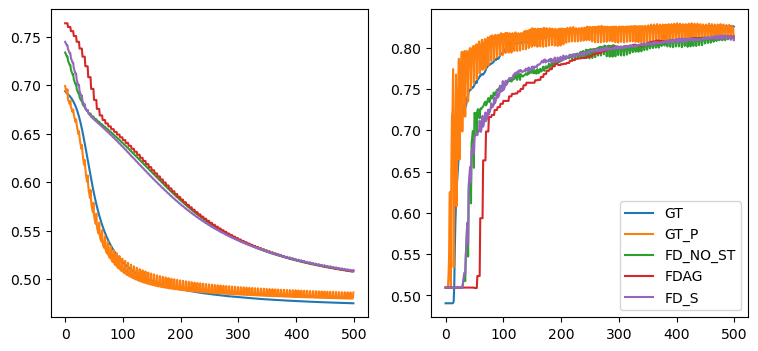

In [40]:
def plot(result, name):
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    for d, n in zip(result, name):
        train_loss, test_loss, test_accuracy = d
        if len(test_loss) < 200:
            test_loss = [item for item in test_loss for _ in range(5)]
            test_accuracy = [item for item in test_accuracy for _ in range(5)]

#         ax[0].plot(train_loss, label=n)
        ax[0].plot(test_loss, label=n)
        ax[1].plot(test_accuracy, label=n)
    ax[1].legend()
    plt.show()
    
plot([res1, res2, res3, res4, res5] , ["GT", "GT_P", "FD_NO_ST", "FDAG", "FD_S"])


In [ ]:

    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=64,
                               dim_out=args.num_classes)
            
    elif args.model == 'qmlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = QMLP(dim_in=len_in, dim_hidden=64,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')

    # Set the model to train and send it to device.
    global_model.to(device)
    global_model.train()
    print(global_model)

    # copy weights
    global_weights = global_model.state_dict()

    # Training
    train_loss, train_accuracy = [], []
    val_acc_list, net_list = [], []
    cv_loss, cv_acc = [], []
    print_every = 2
    val_loss_pre, counter = 0, 0

    for epoch in tqdm(range(args.epochs)):
        local_weights, local_losses = [], []
        print(f'\n | Global Training Round : {epoch+1} |\n')

        global_model.train()
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=train_dataset,
                                      idxs=user_groups[idx], logger=logger)
            w, loss = local_model.update_weights(
                model=copy.deepcopy(global_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(copy.deepcopy(loss))

        # update global weights
        global_weights = average_weights(local_weights)

        # update global weights
        global_model.load_state_dict(global_weights)

        loss_avg = sum(local_losses) / len(local_losses)
        train_loss.append(loss_avg)

        # Calculate avg training accuracy over all users at every epoch
        list_acc, list_loss = [], []
        global_model.eval()
        for c in range(args.num_users):
            local_model = LocalUpdate(args=args, dataset=train_dataset,
                                      idxs=user_groups[idx], logger=logger)
            acc, loss = local_model.inference(model=global_model)
            list_acc.append(acc)
            list_loss.append(loss)
        train_accuracy.append(sum(list_acc)/len(list_acc))

        # print global training loss after every 'i' rounds
        if (epoch+1) % print_every == 0:
            print(f' \nAvg Training Stats after {epoch+1} global rounds:')
            print(f'Training Loss : {np.mean(np.array(train_loss))}')
            print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))

    # Test inference after completion of training
    test_acc, test_loss = test_inference(args, global_model, test_dataset)

    print(f' \n Results after {args.epochs} global rounds of training:')
    print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
    print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

    # Saving the objects train_loss and train_accuracy:
    file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
        format(args.dataset, args.model, args.epochs, args.frac, args.iid,
               args.local_ep, args.local_bs)

    with open(file_name, 'wb') as f:
        pickle.dump([train_loss, train_accuracy], f)

    print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))